# MNIST Digit Classifier

## Team
  * **Members**:  *Awantee (s8awdesh@stud.uni-saarland.de), Daniel (s8daberr@stud.uni-saarland.de), Shubham (s8shagar@stud.uni-saarland.de)*
  
## About this Project
In this project, we implement a digit classifier, based on the popular [MNIST](http://yann.lecun.com/exdb/mnist/) dataset.
This dataset consists of data $\mathcal{D} = \{x_i, y_i\}_{i=1}^N$, where $x_i$ is a 28x28 pixel grayscale image and $y_i$ is a scalar represeting digits between 0-9.


In [0]:
import time 
 
import numpy as np 
import matplotlib.pyplot as plt 

import json 
import time 
import pickle 
import sys 
import csv 
import os 
import os.path as osp 
import shutil 

import pandas as pd

from IPython.display import display, HTML
 
%matplotlib inline 
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots 
plt.rcParams['image.interpolation'] = 'nearest' 
plt.rcParams['image.cmap'] = 'gray' 
 
# for auto-reloading external modules 
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython 
%load_ext autoreload
%autoreload 2

In [0]:
import random
import struct

from sklearn import neighbors, metrics
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn import svm, metrics, model_selection

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms

random_seed = 1
torch.backends.cudnn.enabled = True
torch.manual_seed(random_seed)

Helper methods

In [0]:
def identity_func(foo):
    return foo

# You can use this function to flatten 2D inputs
def flatten_input_pixels(x_input):
    result = []
    for i in range(len(x_input)):
        result.append(x_input[i].flatten())
    return np.array(result, np.uint8)  # [n_samples, n_features]


# You can use this function to plot the accuracy of the models with different parametes
def plot_scores(x, y, title = "Title", x_label = "X", y_label = "Y"):
    fig, ax = plt.subplots(nrows=1,ncols=1)

    ax.plot(x, y)
    ax.set_xticks(x)
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_ylim(0.1, 1.0)

# You can use this function to visualize input images and the predictions of your models
# "y_pred" is output of your model 
# "n_val" is number of instances in test or validation sets
def vis_predictions(x_eval, y_pred, n_val):
    rows, cols = 4, 3

    fig,ax = plt.subplots(nrows = rows, ncols = cols)

    ids = np.random.randint(0,n_val,rows*cols)
    for i in range(cols):   
        for j in range(rows):
            ax[j][i].set_title('predicted label: {0}'. format(y_pred[ids[(i*rows)+j]]))
            two_d = (np.reshape(x_eval[ids[(i*rows)+j]], (28, 28))).astype(np.uint8)
            ax[j][i].imshow(two_d)
            ax[j][i].axes.get_xaxis().set_visible(False)
            ax[j][i].axes.get_yaxis().set_visible(False)


    plt.tight_layout()  

# 1. Load and Visualise data


## 1.1. Load Data


In [0]:
batch_size_train = 10000
batch_size_test = 1000
n_epochs = 5

train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('../MLCS/', train = True, download = True,
        transform = torchvision.transforms.Compose([
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize((0.1307,), (0.3081,))
        ])),
    batch_size = batch_size_train, shuffle = True)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('../MLCS/', train = False, download = True,
        transform = torchvision.transforms.Compose([
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize((0.1307,), (0.3081,))
        ])),
    batch_size = batch_size_test, shuffle = True)

train_data = enumerate(train_loader)
batch_idx, (x_trainval, y_trainval) = next(train_data)
test_data = enumerate(test_loader)
batch_idx, (x_test, y_test) = next(test_data)
print('x_trainval.shape = {},  y_trainval.shape = {}'.format(x_trainval.shape, y_trainval.shape))
print('x_test.shape = {},  y_test.shape = {}'.format(x_test.shape, y_test.shape))

DEBUG_FRAC = 1.0
x_trainval = x_trainval[:int(len(x_trainval)*DEBUG_FRAC)]
y_trainval = y_trainval[:int(len(y_trainval)*DEBUG_FRAC)]

x_trainval.shape = torch.Size([10000, 1, 28, 28]),  y_trainval.shape = torch.Size([10000])
x_test.shape = torch.Size([1000, 1, 28, 28]),  y_test.shape = torch.Size([1000])


#### 1.2. Visualize Data


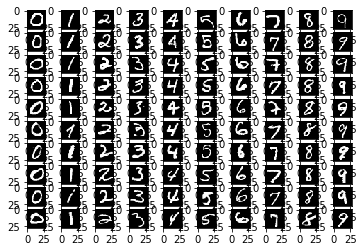

In [0]:
rows, cols = 10, 10
fig,ax = plt.subplots(nrows = rows, ncols = cols)

for digit in range(0, 10):
    indexPosList = []
    for position, data in enumerate(y_trainval):
        if data == digit:
            indexPosList.append(position)
        if len(indexPosList) >= 10:
            break;
    indexSamples = random.sample(indexPosList, k=10)
    counter = 0
    for index in indexSamples:
        ax[counter, digit].imshow(x_trainval[index][0])
        counter = counter + 1

plt.savefig('fig1.pdf')
plt.show()

# 2. Digit classifiers








## 2.1: Model [M1]: *k-Nearest Neighbors*

K-NN (K-Nearest Neighbours) is one of the most basic algorithms in supervised learning. It is a feature selection algorithm used for classification and regression purposes, in general. The premise behind this algorithm is that all similar objects lie in close proximity to each other. 

It consists of coming with a predetermined number *k* of training samples closest in distance to a new sample *s* whose class has to be determined. To find those points, the algorithm calculates the euclidean distance between *s* and all training points and selects only the *k* nearest to *s*. The digit with the most points in the class will be taken as the new label of s. We try to find similarity between datapoints as per their labels and then use it for testing unseen datapoints.

### 2.1.1: Hyper-parameters

The hyperparameters selected for this model are the value for *k* and the weights and algorithm used for classifying training datasets. 

In [0]:
weights = 'distance'
algorithm = 'kd_tree'
leaf_size = 20

degree = np.asarray([1,2,3]) # example

test_set = 'val'  #  or 'test'

if test_set == 'val':
    train_idxs, val_idxs = range(0,int(0.75*len(x_trainval[:10000]))), range(int(0.75*len(x_trainval[:10000])),len(x_trainval[:10000]))
    x_train, y_train = x_trainval[train_idxs], y_trainval[train_idxs]
    x_eval, y_eval = x_trainval[val_idxs], y_trainval[val_idxs]
else:
    x_train, y_train = x_trainval, y_trainval
    x_eval, y_eval = x_test, y_test

### 2.1.2: Data Preprocessing


In [0]:
np.random.seed(0)

x_train = x_train.numpy()
y_train = y_train.numpy()
x_eval = x_eval.numpy()
y_eval = y_eval.numpy()
x_test = x_test.numpy()
y_test = y_test.numpy()

nsamples, c, nx, ny = x_train.shape
x_train = x_train.reshape((nsamples,nx*ny))

nsamples, c, nx, ny = x_eval.shape
x_eval = x_eval.reshape((nsamples,nx*ny))

nsamples, c, nx, ny = x_test.shape
x_test = x_test.reshape((nsamples,nx*ny))

x_train = flatten_input_pixels(x_train)
x_eval = flatten_input_pixels(x_eval)
x_test = flatten_input_pixels(x_test)

### 2.1.3: Model

We iterate over different values of *k*, i.e., we learn from different size of groups with identical features in datapoints to train the model. The model is trained over values of *k* ranging over 1 to 10 and report the accuracy. The, we use the the *k* value for which we achieved best performance while training, to build a kNN model and then test datapoints on this model itself.

In [0]:
kVals = range(1, 11)
accuracies = []

for k in range(1, 11):
    model = neighbors.KNeighborsClassifier(n_neighbors=k, weights=weights, algorithm=algorithm, leaf_size=leaf_size, n_jobs=-1)
    model.fit(x_train, y_train)
 
    score = model.score(x_eval, y_eval)
    print("k=%d, accuracy=%.2f%%" % (k, score * 100))
    accuracies.append(score)

i = int(np.argmax(accuracies))
kNNModel = neighbors.KNeighborsClassifier(n_neighbors=kVals[i])

k=1, accuracy=92.20%
k=2, accuracy=92.16%
k=3, accuracy=92.40%
k=4, accuracy=92.52%
k=5, accuracy=92.12%
k=6, accuracy=92.60%
k=7, accuracy=92.24%
k=8, accuracy=92.20%
k=9, accuracy=91.92%
k=10, accuracy=91.84%


### 2.1.4: Fit Model

No optimization technique was explicitly required for this model. We fit the model and save it into a file for further validation and testing purpose.

In [0]:
kNNModel.fit(x_train, y_train)
kNNFile = 'knn_model.sav'
pickle.dump(kNNModel, open(kNNFile, 'wb'))

### 2.1.5: Evaluation



In [0]:
predictions = kNNModel.predict(x_test)
print(metrics.classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.93      1.00      0.97        98
           1       0.80      1.00      0.89       108
           2       1.00      0.90      0.95       100
           3       0.88      0.90      0.89       110
           4       0.94      0.93      0.93        96
           5       0.94      0.88      0.91        93
           6       0.98      0.99      0.98        86
           7       0.92      0.89      0.90       105
           8       0.98      0.85      0.91       101
           9       0.91      0.88      0.90       103

    accuracy                           0.92      1000
   macro avg       0.93      0.92      0.92      1000
weighted avg       0.93      0.92      0.92      1000



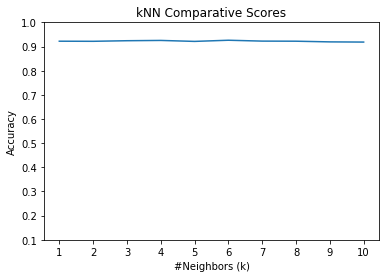

In [0]:
plot_scores(kVals, accuracies, title="kNN Comparative Scores", x_label='#Neighbors (k)', y_label='Accuracy')

In [0]:
print("Best Accuracy", kNNModel.score(x_eval, y_eval)*100, '%')

Best Accuracy 91.60000000000001 %


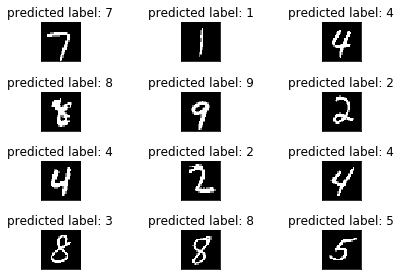

In [0]:
vis_predictions(x_test, predictions, len(predictions))

### 2.1.6: Summary

One major advantage of **KNN** is the low complexity. The training set can almost immediately be used and data samples can be added or removed at any point. 
 The precision scales with the amount of training data samples, which are directly used to evaluate new samples, which also means that the evaluation phase will lengthen with a higher amount of training images. 

To mitigate this effect, algorithms like *'kd-tree'* can be used to fasten the search for near samples, which uses a concept similar to binary search to find near objects faster. 

Another important aspect for increasing the speed is the distance algorithm. Eucledian distance worked best on the testing dataset.

The most important hyperparameter is the *k* value, which states how many near points will be compared. Choosing a low *k* will lead to an more precise result but the complexity will also increase, which leads to unnessecary specification of the function and will make it more likely that falsely classified outliner points will distort the result. Chosing a high k will lead in generalized models but will also loose informations. In our model, 6 turned out to be the best value for k. 

One possibility to increase the effect even more is to not give each training sample the same weight but to weight points near to the point to classify s stronger than others. In our tests, this effect was minor but in other datasets, this factor could be as important as k for reaching the best possible score.

All in all, the biggest advantage of this model is its flexibility, its low complexity and the lack of a training phase. Drawbacks are the lower precision and the slowness on large datasets.

# 2.2: Model [M2]: *SVM*

In Support Vector Machines, or SVMs, we divide the data by finding a hyperplane that divides the different classes, where the data points are scattered in an n-dimensional space. The coordinate of every observation is termed as a Support Vector. A good SVM chooses a hyperplane with a large margin, whereby new data can be classified correctly within the margin. 

If the data is not linearly separable in space, a process called kerneling is used to map these points into higher dimensions, thereby making them separable. 

### 2.2.1: Hyper-parameters

Following parameters are used to tweak the SVM Model:

*e.g. sklearn.svm.SVC(C=1.0, kernel='rbf', degree=3, gamma=0.0, coef0=0.0, shrinking=True, probability=False,tol=0.001, cache_size=200, class_weight=None, verbose=False, max_iter=-1, random_state=None)*

1) kernel - to select the type of hyperplane used to separate the data
eg. linear, radial basis function, polynomial

2) gamma - a higher value of gamma indicates a better fit over the training set

3) C - penalty parameter of the error term. It controls the tradeoff between a smooth decision boundary and the correct classification of training points. 

4) degree - used for the polynomial SVM to denote the degree of the polynomial function 

In [0]:
C_values= [1, 5, 10]
gamma_values = [0.01, 0.001]
kernel_values = ['linear', 'rbf', 'poly']

degree = np.asarray([1,2,3])

test_set = 'val'

if test_set == 'val':
    train_idxs, val_idxs = range(0,int(0.75*len(x_trainval[:10000]))), range(int(0.75*len(x_trainval[:10000])),len(x_trainval[:10000]))
    x_train, y_train = x_trainval[train_idxs], y_trainval[train_idxs]
    x_eval, y_eval = x_trainval[val_idxs], y_trainval[val_idxs]
else:
    x_train, y_train = x_trainval, y_trainval
    x_eval, y_eval = x_test, y_test

### 2.2.2: Data Preprocessing


In [0]:
x_train = x_train.numpy()
y_train = y_train.numpy()
x_eval = x_eval.numpy()
y_eval = y_eval.numpy()

nsamples, c, nx, ny = x_train.shape
x_train = x_train.reshape((nsamples,nx*ny))

nsamples, c, nx, ny = x_eval.shape
x_eval = x_eval.reshape((nsamples,nx*ny))

x_train = flatten_input_pixels(x_train)
x_eval = flatten_input_pixels(x_eval)

### 2.2.3: Model

We construct three traditional Machine Learning models based on distance vector learning. Here, we have three SVM Models, i.e. linear, radial and polynomial, each of which tries to find a distinguishing hyperplanes between multiple classes in the dataset.
We compare the performance of these three models to understand the behavior of these kinds of datapoints and pick the best one at the end.

In [0]:
linearKernel = svm.SVC(C=C_values[0], kernel=kernel_values[0], verbose=True)
rbfKernel = svm.SVC(C=C_values[1], gamma = gamma_values[0], kernel=kernel_values[1], verbose=True)
polynomialKernel = svm.SVC(C=C_values[2], gamma = gamma_values[0], kernel=kernel_values[2], verbose=True)

### 2.2.4: Fit Model


In [0]:
print(linearKernel)
linearKernel.fit(x_train, y_train)

print(rbfKernel)
rbfKernel.fit(x_train, y_train)

print(polynomialKernel)
polynomialKernel.fit(x_train, y_train)

from sklearn.externals import joblib
linear_file = 'linear_SVM_model.sav'
joblib.dump(linearKernel, linear_file)
rbf_file = 'rbf_SVM_model.sav'
joblib.dump(rbfKernel, rbf_file)
poly_file = 'polynomial_SVM_model.sav'
joblib.dump(polynomialKernel, poly_file)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=True)
[LibSVM]SVC(C=5, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=True)
[LibSVM]SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='poly',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=True)
[LibSVM]

C:\Users\agarw\.conda\envs\cysecml\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


['polynomial_SVM_model.sav']

### 2.2.5: Evaluation

Evaluate your model.
  * Evaluate models with different parameters 
  * Plot score (accuracy) for each model using "plot_scores" function
  * Report the score for the best model
  * Use "vis_predictions" function to visualize few examples of test/validation set with the corresponding predictions


Linear Kernel Accuracy in % :  89.60000000000001
RBF Kernel Accuracy in % :  95.96000000000001
Polynomial Kernel Accuracy in % :  93.76


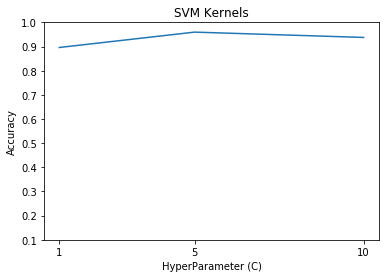

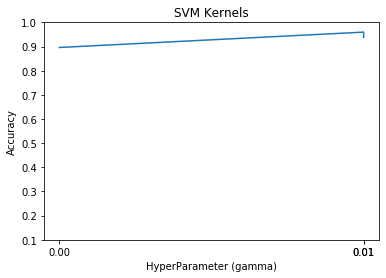

In [0]:
linear_predict_result = linearKernel.predict(x_eval)
rbf_predict_result = rbfKernel.predict(x_eval)
poly_predict_result = polynomialKernel.predict(x_eval)

linearScore = linearKernel.score(x_eval, y_eval)
print("Linear Kernel Accuracy in % : ", linearScore*100)

rbfScore = rbfKernel.score(x_eval, y_eval)
print("RBF Kernel Accuracy in % : ", rbfScore*100)

polyScore = polynomialKernel.score(x_eval, y_eval)
print("Polynomial Kernel Accuracy in % : ", polyScore*100)

linearParams = linearKernel.get_params()
rbfParams = rbfKernel.get_params()
polynomialParams = polynomialKernel.get_params()

plot_scores([linearParams['C'], rbfParams['C'], polynomialParams['C']],
            [linearScore, rbfScore, polyScore],
            "SVM Kernels", x_label='HyperParameter (C)', y_label='Accuracy')

plot_scores([0, rbfParams['gamma'], polynomialParams['gamma']],
            [linearScore, rbfScore, polyScore],
            "SVM Kernels", x_label='HyperParameter (gamma)', y_label='Accuracy')

In [0]:
print("Linear Kernel Score in % : ", linearScore*100)
print("RBF Kernel Score in % : ", rbfScore*100)
print("Polynomial Kernel Score in % : ", polyScore*100)

linearMetrics = metrics.classification_report(y_eval, linear_predict_result)
print("\nLinear Classification Report : \n ", linearMetrics)
rbfMetrics = metrics.classification_report(y_eval, rbf_predict_result)
print("\nRBF Classification Report : \n ", rbfMetrics)
polynomialMetrics = metrics.classification_report(y_eval, poly_predict_result)
print("\nPolynomial Classification Report : \n ", polynomialMetrics)

Linear Kernel Score in % :  89.60000000000001
RBF Kernel Score in % :  95.96000000000001
Polynomial Kernel Score in % :  93.76

Linear Classification Report : 
                precision    recall  f1-score   support

           0       0.94      0.96      0.95       226
           1       0.92      0.99      0.96       282
           2       0.86      0.90      0.88       261
           3       0.88      0.87      0.87       260
           4       0.89      0.90      0.90       225
           5       0.87      0.82      0.85       226
           6       0.94      0.96      0.95       263
           7       0.88      0.93      0.90       243
           8       0.90      0.83      0.86       263
           9       0.88      0.78      0.83       251

    accuracy                           0.90      2500
   macro avg       0.90      0.90      0.89      2500
weighted avg       0.90      0.90      0.89      2500


RBF Classification Report : 
                precision    recall  f1-score   s

Predictions in Linear Predictions:

Predictions in RBF Predictions:

Predictions in Polynomial Predictions:



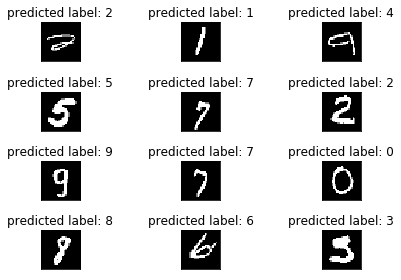

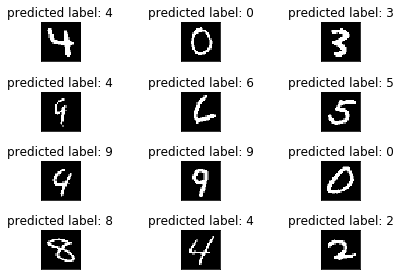

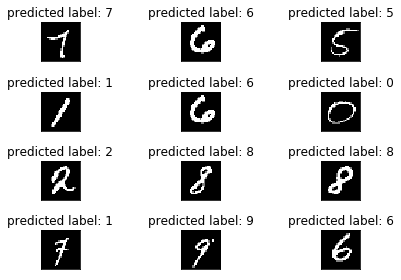

In [0]:
print("Predictions in Linear Predictions:\n")
vis_predictions(x_eval, linear_predict_result, len(x_eval))

print("Predictions in RBF Predictions:\n")
vis_predictions(x_eval, rbf_predict_result, len(x_eval))

print("Predictions in Polynomial Predictions:\n")
vis_predictions(x_eval, poly_predict_result, len(x_eval))

### 2.2.6: Summary

The choice of the kernel is obviously very important in the SVM model. It is observed that the training time for RBF and polynomial SVM is greater than that for linear SVMs, but the accuracy of these two is also higher. 

After testing our dataset on all three models over different hyperparameters, we understand that a linear classification for these datapoints is not sufficient, and we would require non-linear methods to handle them. For example, we encountered digits with little differences but with different labels between 9 and 7 potentially because of handwritings where linear classification model failed but the rbf or polynomial performed significantly well to understand minute subtleties in the data points.

# 2.3: Model [M3] (Neural Networks):



### 2.3.1: Hyper-parameters


In [0]:
batch_size_train = 64
batch_size_test = 1000
n_epochs = 5

learning_rate = 0.01
momentum = 0.5
log_interval = 10
dropout_1 = 0.1
dropout_2 = 0.5
dropout_3 = 0.9

random_seed = 1
torch.backends.cudnn.enabled = True
torch.manual_seed(random_seed)

train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('../MLCS/', train = True, download = True,
        transform = torchvision.transforms.Compose([
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize((0.1307,), (0.3081,))
        ])),
    batch_size = batch_size_train, shuffle = True)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('../MLCS/', train = False, download = True,
        transform = torchvision.transforms.Compose([
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize((0.1307,), (0.3081,))
        ])),
    batch_size = batch_size_test, shuffle = True)

train_data = enumerate(train_loader)
batch_idx, (x_trainval, y_trainval) = next(train_data)
test_data = enumerate(test_loader)
batch_idx, (x_test, y_test) = next(test_data)

print('x_trainval.shape = {},  y_trainval.shape = {}'.format(x_trainval.shape, y_trainval.shape))
print('x_test.shape = {},  y_test.shape = {}'.format(x_test.shape, y_test.shape))

DEBUG_FRAC = 1.0
x_trainval = x_trainval[: int(len(x_trainval) * DEBUG_FRAC)]
y_trainval = y_trainval[: int(len(y_trainval) * DEBUG_FRAC)]

test_set = 'test'

if test_set == 'val':
    train_idxs, val_idxs = range(0,int(0.75*len(x_trainval))), range(int(0.75*len(x_trainval)),len(x_trainval))
    x_train, y_train = x_trainval[train_idxs], y_trainval[train_idxs]
    x_eval, y_eval = x_trainval[val_idxs], y_trainval[val_idxs]
else:
    x_train, y_train = x_trainval, y_trainval
    x_eval, y_eval = x_test, y_test

x_trainval.shape = torch.Size([64, 1, 28, 28]),  y_trainval.shape = torch.Size([64])
x_test.shape = torch.Size([1000, 1, 28, 28]),  y_test.shape = torch.Size([1000])


### 2.3.2: Model


In [0]:
class Net_1(nn.Module):
    def __init__(self):
        super(Net_1, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        
        self.conv2_drop = nn.Dropout2d(dropout_1)
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)
    
class Net_2(nn.Module):
    def __init__(self):
        super(Net_2, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        
        self.conv2_drop = nn.Dropout2d(dropout_2)
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)
    
class Net_3(nn.Module):
    def __init__(self):
        super(Net_3, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        
        self.conv2_drop = nn.Dropout2d(dropout_3)
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

### 2.3.3: Fit Model


In [0]:
loss_function_1 = nn.CrossEntropyLoss()
loss_function_2 = F.nll_loss

network_1 = Net_1()
optimizer_1 = optim.Adam(network_1.parameters(), lr=learning_rate)
print(network_1)

network_2 = Net_2()
optimizer_2 = optim.SGD(network_2.parameters(), lr=learning_rate, momentum=momentum)
print(network_2)

network_3 = Net_3()
optimizer_3 = optim.SGD(network_3.parameters(), lr=learning_rate, momentum=momentum)
print(network_3)

train_losses_1 = []
train_counter_1 = []
test_losses_1 = []
test_counter_1 = [i*len(train_loader.dataset) for i in range(0,n_epochs)]

train_losses_2 = []
train_counter_2 = []
test_losses_2 = []
test_counter_2 = [i*len(train_loader.dataset) for i in range(0,n_epochs)]

train_losses_3 = []
train_counter_3 = []
test_losses_3 = []
test_counter_3 = [i*len(train_loader.dataset) for i in range(0,n_epochs)]

Net_1(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.1, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)
Net_2(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)
Net_3(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.9, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)


In [0]:
def train_1(epoch):
    network_1.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer_1.zero_grad()
        output = network_1(data)
        loss = loss_function_1(output, target)
        loss.backward()
        optimizer_1.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(data), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), loss.item()))
        train_losses_1.append(loss.item())
        train_counter_1.append(
            (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
        torch.save(network_1.state_dict(), 'mode_1_' + str(epoch) + '.pth')
        torch.save(optimizer_1.state_dict(), 'optimizer_1_' + str(epoch) + '.pth')

In [0]:
def train_2(epoch):
    network_2.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer_2.zero_grad()
        output = network_2(data)
        loss = loss_function_2(output, target)
        loss.backward()
        optimizer_2.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(data), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), loss.item()))
        train_losses_2.append(loss.item())
        train_counter_2.append(
            (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
        torch.save(network_2.state_dict(), 'mode_2_' + str(epoch) + '.pth')
        torch.save(optimizer_2.state_dict(), 'optimizer_2_' + str(epoch) + '.pth')

In [0]:
def train_3(epoch):
    network_3.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer_3.zero_grad()
        output = network_3(data)
        loss = loss_function_2(output, target)
        loss.backward()
        optimizer_3.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(data), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), loss.item()))
        train_losses_3.append(loss.item())
        train_counter_3.append(
            (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
        torch.save(network_3.state_dict(), 'mode_3_' + str(epoch) + '.pth')
        torch.save(optimizer_3.state_dict(), 'optimizer_3_' + str(epoch) + '.pth')

In [0]:
test_accuracy_1 = []
def test_1():
    network_1.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = network_1(data)
            test_loss += loss_function_1(output, target).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
        test_loss /= len(test_loader.dataset)
        test_losses_1.append(test_loss)
        print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
        test_accuracy_1.append(100. * correct / len(test_loader.dataset))

In [0]:
test_accuracy_2 = []
def test_2():
    network_2.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = network_2(data)
            test_loss += loss_function_2(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
        test_loss /= len(test_loader.dataset)
        test_losses_2.append(test_loss)
        print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
        test_accuracy_2.append(100. * correct / len(test_loader.dataset))

In [0]:
test_accuracy_3 = []
def test_3():
    network_3.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = network_3(data)
            test_loss += loss_function_2(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
        test_loss /= len(test_loader.dataset)
        test_losses_3.append(test_loss)
        print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
        test_accuracy_3.append(100. * correct / len(test_loader.dataset))

In [0]:
print("Training & Testing on CNN Model 1 - Adam as Optimizer & Dropout = 0.1")
for epoch in range(1, n_epochs + 1):
    train_1(epoch)
    test_1()
    
print("Training & Testing on CNN Model 2 - SGD as Optimizer & Dropout = 0.5")
for epoch in range(1, n_epochs + 1):  
    train_2(epoch)
    test_2()
    
print("Training & Testing on CNN Model 2 - SGD as Optimizer & Dropout = 0.9")
for epoch in range(1, n_epochs + 1):  
    train_3(epoch)
    test_3()

Training & Testing on CNN Model 1 - Adam as Optimizer & Dropout = 0.1


C:\Users\agarw\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.292933
Train Epoch: 1 [640/60000 (1%)]	Loss: 1.919890
Train Epoch: 1 [1280/60000 (2%)]	Loss: 1.695652
Train Epoch: 1 [1920/60000 (3%)]	Loss: 1.195018
Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.776031
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.761919
Train Epoch: 1 [3840/60000 (6%)]	Loss: 1.026225
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.779877
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.608266
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.781585
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.394283
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.888395
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.171117
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.499001
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.536358
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.802395
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.605799
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.727692
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.483125
Train Epoch: 1 [12160/60000 (20%)]	Loss: 0.349446
Train Epoch: 1 [12800/60000 (

Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.389493
Train Epoch: 2 [45440/60000 (76%)]	Loss: 0.488625
Train Epoch: 2 [46080/60000 (77%)]	Loss: 0.285879
Train Epoch: 2 [46720/60000 (78%)]	Loss: 0.198636
Train Epoch: 2 [47360/60000 (79%)]	Loss: 0.386156
Train Epoch: 2 [48000/60000 (80%)]	Loss: 0.282181
Train Epoch: 2 [48640/60000 (81%)]	Loss: 0.248372
Train Epoch: 2 [49280/60000 (82%)]	Loss: 0.190819
Train Epoch: 2 [49920/60000 (83%)]	Loss: 0.333795
Train Epoch: 2 [50560/60000 (84%)]	Loss: 0.448873
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.195284
Train Epoch: 2 [51840/60000 (86%)]	Loss: 0.670428
Train Epoch: 2 [52480/60000 (87%)]	Loss: 0.395394
Train Epoch: 2 [53120/60000 (88%)]	Loss: 0.285377
Train Epoch: 2 [53760/60000 (90%)]	Loss: 0.336917
Train Epoch: 2 [54400/60000 (91%)]	Loss: 0.129739
Train Epoch: 2 [55040/60000 (92%)]	Loss: 0.149968
Train Epoch: 2 [55680/60000 (93%)]	Loss: 0.123252
Train Epoch: 2 [56320/60000 (94%)]	Loss: 0.124268
Train Epoch: 2 [56960/60000 (95%)]	Loss: 0.308120


Train Epoch: 4 [28800/60000 (48%)]	Loss: 0.344183
Train Epoch: 4 [29440/60000 (49%)]	Loss: 0.109485
Train Epoch: 4 [30080/60000 (50%)]	Loss: 0.153023
Train Epoch: 4 [30720/60000 (51%)]	Loss: 0.283053
Train Epoch: 4 [31360/60000 (52%)]	Loss: 0.353761
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.171392
Train Epoch: 4 [32640/60000 (54%)]	Loss: 0.265232
Train Epoch: 4 [33280/60000 (55%)]	Loss: 0.171654
Train Epoch: 4 [33920/60000 (57%)]	Loss: 0.158035
Train Epoch: 4 [34560/60000 (58%)]	Loss: 0.262880
Train Epoch: 4 [35200/60000 (59%)]	Loss: 0.319055
Train Epoch: 4 [35840/60000 (60%)]	Loss: 0.138189
Train Epoch: 4 [36480/60000 (61%)]	Loss: 0.290992
Train Epoch: 4 [37120/60000 (62%)]	Loss: 0.248777
Train Epoch: 4 [37760/60000 (63%)]	Loss: 0.432276
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.284677
Train Epoch: 4 [39040/60000 (65%)]	Loss: 0.316089
Train Epoch: 4 [39680/60000 (66%)]	Loss: 0.346293
Train Epoch: 4 [40320/60000 (67%)]	Loss: 0.325325
Train Epoch: 4 [40960/60000 (68%)]	Loss: 0.071722


C:\Users\agarw\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:37: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train Epoch: 1 [640/60000 (1%)]	Loss: 2.280854
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.259353
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.221901
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.136423
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.127253
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.072015
Train Epoch: 1 [4480/60000 (7%)]	Loss: 1.894501
Train Epoch: 1 [5120/60000 (9%)]	Loss: 1.990166
Train Epoch: 1 [5760/60000 (10%)]	Loss: 1.847935
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.625875
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.587813
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.670049
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.318312
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.447737
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.199918
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.183497
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.302779
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.844772
Train Epoch: 1 [12160/60000 (20%)]	Loss: 0.917073
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.935682
Train Epoch: 1 [13440/60

C:\Users\agarw\.conda\envs\cysecml\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.1962, Accuracy: 9424/10000 (94%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.340694
Train Epoch: 2 [640/60000 (1%)]	Loss: 0.470427
Train Epoch: 2 [1280/60000 (2%)]	Loss: 0.424039
Train Epoch: 2 [1920/60000 (3%)]	Loss: 0.422702
Train Epoch: 2 [2560/60000 (4%)]	Loss: 0.390378
Train Epoch: 2 [3200/60000 (5%)]	Loss: 0.543611
Train Epoch: 2 [3840/60000 (6%)]	Loss: 0.548837
Train Epoch: 2 [4480/60000 (7%)]	Loss: 0.545766
Train Epoch: 2 [5120/60000 (9%)]	Loss: 0.536714
Train Epoch: 2 [5760/60000 (10%)]	Loss: 0.531553
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.477741
Train Epoch: 2 [7040/60000 (12%)]	Loss: 0.256106
Train Epoch: 2 [7680/60000 (13%)]	Loss: 0.371331
Train Epoch: 2 [8320/60000 (14%)]	Loss: 0.409845
Train Epoch: 2 [8960/60000 (15%)]	Loss: 0.272623
Train Epoch: 2 [9600/60000 (16%)]	Loss: 0.435167
Train Epoch: 2 [10240/60000 (17%)]	Loss: 0.540059
Train Epoch: 2 [10880/60000 (18%)]	Loss: 0.454178
Train Epoch: 2 [11520/60000 (19%)]	Loss: 0.323249
Train Epoch: 2 [12160

Train Epoch: 3 [44160/60000 (74%)]	Loss: 0.404941
Train Epoch: 3 [44800/60000 (75%)]	Loss: 0.087258
Train Epoch: 3 [45440/60000 (76%)]	Loss: 0.267221
Train Epoch: 3 [46080/60000 (77%)]	Loss: 0.433854
Train Epoch: 3 [46720/60000 (78%)]	Loss: 0.241508
Train Epoch: 3 [47360/60000 (79%)]	Loss: 0.123521
Train Epoch: 3 [48000/60000 (80%)]	Loss: 0.248533
Train Epoch: 3 [48640/60000 (81%)]	Loss: 0.267234
Train Epoch: 3 [49280/60000 (82%)]	Loss: 0.181642
Train Epoch: 3 [49920/60000 (83%)]	Loss: 0.214379
Train Epoch: 3 [50560/60000 (84%)]	Loss: 0.278219
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.366293
Train Epoch: 3 [51840/60000 (86%)]	Loss: 0.455593
Train Epoch: 3 [52480/60000 (87%)]	Loss: 0.262464
Train Epoch: 3 [53120/60000 (88%)]	Loss: 0.518418
Train Epoch: 3 [53760/60000 (90%)]	Loss: 0.267575
Train Epoch: 3 [54400/60000 (91%)]	Loss: 0.325490
Train Epoch: 3 [55040/60000 (92%)]	Loss: 0.194737
Train Epoch: 3 [55680/60000 (93%)]	Loss: 0.144239
Train Epoch: 3 [56320/60000 (94%)]	Loss: 0.375613


Train Epoch: 5 [28160/60000 (47%)]	Loss: 0.150737
Train Epoch: 5 [28800/60000 (48%)]	Loss: 0.100284
Train Epoch: 5 [29440/60000 (49%)]	Loss: 0.310928
Train Epoch: 5 [30080/60000 (50%)]	Loss: 0.179671
Train Epoch: 5 [30720/60000 (51%)]	Loss: 0.270913
Train Epoch: 5 [31360/60000 (52%)]	Loss: 0.125127
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.291543
Train Epoch: 5 [32640/60000 (54%)]	Loss: 0.124498
Train Epoch: 5 [33280/60000 (55%)]	Loss: 0.242045
Train Epoch: 5 [33920/60000 (57%)]	Loss: 0.915052
Train Epoch: 5 [34560/60000 (58%)]	Loss: 0.313663
Train Epoch: 5 [35200/60000 (59%)]	Loss: 0.172465
Train Epoch: 5 [35840/60000 (60%)]	Loss: 0.220746
Train Epoch: 5 [36480/60000 (61%)]	Loss: 0.128189
Train Epoch: 5 [37120/60000 (62%)]	Loss: 0.196264
Train Epoch: 5 [37760/60000 (63%)]	Loss: 0.086316
Train Epoch: 5 [38400/60000 (64%)]	Loss: 0.193234
Train Epoch: 5 [39040/60000 (65%)]	Loss: 0.068352
Train Epoch: 5 [39680/60000 (66%)]	Loss: 0.241551
Train Epoch: 5 [40320/60000 (67%)]	Loss: 0.323948


C:\Users\agarw\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:56: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train Epoch: 1 [640/60000 (1%)]	Loss: 2.344465
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.346409
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.273077
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.329205
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.254250
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.263475
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.263486
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.258866
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.222758
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.240734
Train Epoch: 1 [7040/60000 (12%)]	Loss: 2.240013
Train Epoch: 1 [7680/60000 (13%)]	Loss: 2.266492
Train Epoch: 1 [8320/60000 (14%)]	Loss: 2.242810
Train Epoch: 1 [8960/60000 (15%)]	Loss: 2.214152
Train Epoch: 1 [9600/60000 (16%)]	Loss: 2.165596
Train Epoch: 1 [10240/60000 (17%)]	Loss: 2.108884
Train Epoch: 1 [10880/60000 (18%)]	Loss: 2.169003
Train Epoch: 1 [11520/60000 (19%)]	Loss: 2.147803
Train Epoch: 1 [12160/60000 (20%)]	Loss: 2.122511
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.130161
Train Epoch: 1 [13440/60

Train Epoch: 2 [45440/60000 (76%)]	Loss: 0.910605
Train Epoch: 2 [46080/60000 (77%)]	Loss: 0.846173
Train Epoch: 2 [46720/60000 (78%)]	Loss: 0.956355
Train Epoch: 2 [47360/60000 (79%)]	Loss: 1.052609
Train Epoch: 2 [48000/60000 (80%)]	Loss: 0.833843
Train Epoch: 2 [48640/60000 (81%)]	Loss: 1.126201
Train Epoch: 2 [49280/60000 (82%)]	Loss: 0.929563
Train Epoch: 2 [49920/60000 (83%)]	Loss: 0.813094
Train Epoch: 2 [50560/60000 (84%)]	Loss: 0.891126
Train Epoch: 2 [51200/60000 (85%)]	Loss: 1.195555
Train Epoch: 2 [51840/60000 (86%)]	Loss: 0.885515
Train Epoch: 2 [52480/60000 (87%)]	Loss: 0.851081
Train Epoch: 2 [53120/60000 (88%)]	Loss: 1.104273
Train Epoch: 2 [53760/60000 (90%)]	Loss: 1.124505
Train Epoch: 2 [54400/60000 (91%)]	Loss: 0.978125
Train Epoch: 2 [55040/60000 (92%)]	Loss: 0.846541
Train Epoch: 2 [55680/60000 (93%)]	Loss: 0.723836
Train Epoch: 2 [56320/60000 (94%)]	Loss: 1.104850
Train Epoch: 2 [56960/60000 (95%)]	Loss: 0.969532
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.852902


Train Epoch: 4 [29440/60000 (49%)]	Loss: 1.010093
Train Epoch: 4 [30080/60000 (50%)]	Loss: 0.944981
Train Epoch: 4 [30720/60000 (51%)]	Loss: 0.890001
Train Epoch: 4 [31360/60000 (52%)]	Loss: 0.862270
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.878573
Train Epoch: 4 [32640/60000 (54%)]	Loss: 0.579370
Train Epoch: 4 [33280/60000 (55%)]	Loss: 0.837413
Train Epoch: 4 [33920/60000 (57%)]	Loss: 0.739731
Train Epoch: 4 [34560/60000 (58%)]	Loss: 1.042060
Train Epoch: 4 [35200/60000 (59%)]	Loss: 0.630591
Train Epoch: 4 [35840/60000 (60%)]	Loss: 1.001281
Train Epoch: 4 [36480/60000 (61%)]	Loss: 0.924714
Train Epoch: 4 [37120/60000 (62%)]	Loss: 0.972424
Train Epoch: 4 [37760/60000 (63%)]	Loss: 0.782045
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.837844
Train Epoch: 4 [39040/60000 (65%)]	Loss: 0.860831
Train Epoch: 4 [39680/60000 (66%)]	Loss: 0.818228
Train Epoch: 4 [40320/60000 (67%)]	Loss: 0.849206
Train Epoch: 4 [40960/60000 (68%)]	Loss: 1.076013
Train Epoch: 4 [41600/60000 (69%)]	Loss: 0.989999


### 2.3.5: Evaluation

  * Loss curves: Epoch vs loss
  * Accuracy curves: Epoch vs accuracy over val/test set
  * Final accuracy numbers

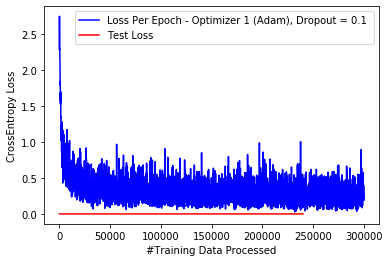

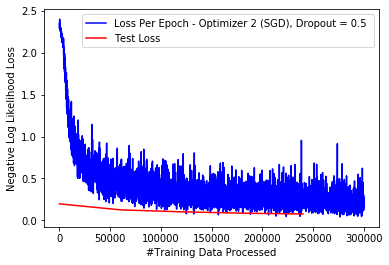

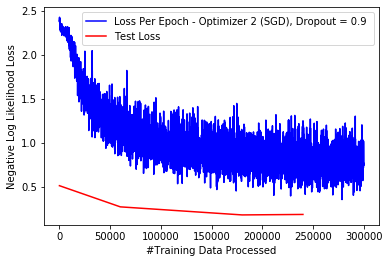

In [0]:
plt.plot(train_counter_1, train_losses_1, color='blue')
plt.plot(test_counter_1, test_losses_1, color='red')
plt.legend(['Loss Per Epoch - Optimizer 1 (Adam), Dropout = 0.1 ', 'Test Loss'], loc='upper right')
plt.xlabel('#Training Data Processed')
plt.ylabel('CrossEntropy Loss')
plt.show()

plt.plot(train_counter_2, train_losses_2, color='blue')
plt.plot(test_counter_2, test_losses_2, color='red')
plt.legend(['Loss Per Epoch - Optimizer 2 (SGD), Dropout = 0.5 ', 'Test Loss'], loc='upper right')
plt.xlabel('#Training Data Processed')
plt.ylabel('Negative Log Likelihood Loss')
plt.show()

plt.plot(train_counter_3, train_losses_3, color='blue')
plt.plot(test_counter_3, test_losses_3, color='red')
plt.legend(['Loss Per Epoch - Optimizer 2 (SGD), Dropout = 0.9 ', 'Test Loss'], loc='upper right')
plt.xlabel('#Training Data Processed')
plt.ylabel('Negative Log Likelihood Loss')
plt.show()

C:\Users\agarw\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\agarw\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:37: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\agarw\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:56: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


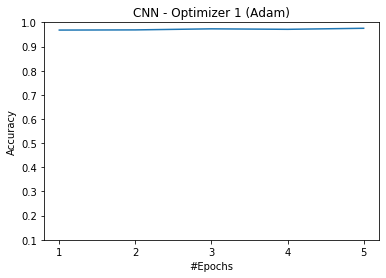

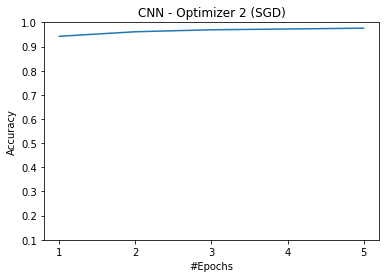

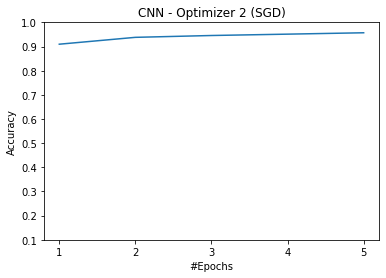

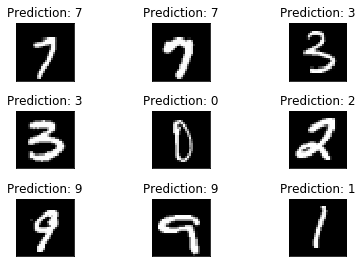

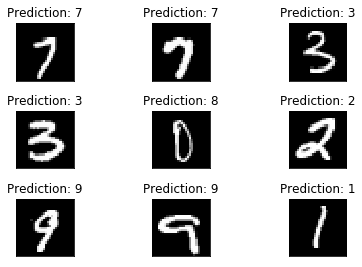

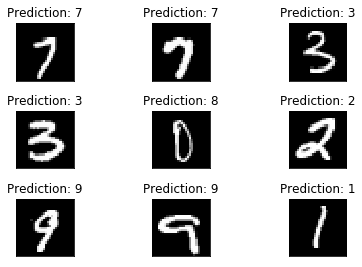

In [0]:
for index in range(0, len(test_accuracy_1)):
    test_accuracy_1[index] = test_accuracy_1[index].item() / 100.0
plot_scores([1,2,3,4,5], test_accuracy_1, title="CNN - Optimizer 1 (Adam)", x_label='#Epochs', y_label='Accuracy')

for index in range(0, len(test_accuracy_2)):
    test_accuracy_2[index] = test_accuracy_2[index].item() / 100.0
plot_scores([1,2,3,4,5], test_accuracy_2, title="CNN - Optimizer 2 (SGD)", x_label='#Epochs', y_label='Accuracy')

for index in range(0, len(test_accuracy_3)):
    test_accuracy_3[index] = test_accuracy_3[index].item() / 100.0
plot_scores([1,2,3,4,5], test_accuracy_3, title="CNN - Optimizer 2 (SGD)", x_label='#Epochs', y_label='Accuracy')
    
with torch.no_grad():
    output_1 = network_1(x_eval)

fig_1 = plt.figure()
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.tight_layout()
    plt.imshow(x_eval[i][0], cmap='gray', interpolation='none')
    plt.title("Prediction: {}".format(output_1.data.max(1, keepdim=True)[1][i].item()))
    plt.xticks([])
    plt.yticks([])
    
with torch.no_grad():
    output_2 = network_2(x_eval)

fig_2 = plt.figure()
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.tight_layout()
    plt.imshow(x_eval[i][0], cmap='gray', interpolation='none')
    plt.title("Prediction: {}".format(output_2.data.max(1, keepdim=True)[1][i].item()))
    plt.xticks([])
    plt.yticks([])
    
with torch.no_grad():
    output_3 = network_3(x_eval)

fig_3 = plt.figure()
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.tight_layout()
    plt.imshow(x_eval[i][0], cmap='gray', interpolation='none')
    plt.title("Prediction: {}".format(output_3.data.max(1, keepdim=True)[1][i].item()))
    plt.xticks([])
    plt.yticks([])

In [0]:
loadedNetwork = Net_2()
loadedOptimizer = optim.SGD(network_2.parameters(), lr=learning_rate, momentum=momentum)

loadedNetwork.load_state_dict(torch.load("mode_2_5.pth"))
loadedOptimizer.load_state_dict(torch.load("optimizer_2_5.pth"))

In [0]:
with torch.no_grad():
    train_output = loadedNetwork(x_train)
    
train_softmax = torch.exp(train_output).cpu()
train_prob = list(train_softmax.numpy())
train_predictions = np.argmax(train_prob, axis=1)

print('Training Set Accuracy in % : ', metrics.accuracy_score(y_train, train_predictions)*100)

with torch.no_grad():
    test_output = loadedNetwork(x_test)
    
test_softmax = torch.exp(test_output).cpu()
test_prob = list(test_softmax.numpy())
test_predictions = np.argmax(test_prob, axis=1)

print('Test Set Accuracy in % : ', metrics.accuracy_score(y_test, test_predictions)*100)

Training Set Accuracy in % :  93.75
Test Set Accuracy in % :  92.60000000000001


C:\Users\agarw\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:37: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


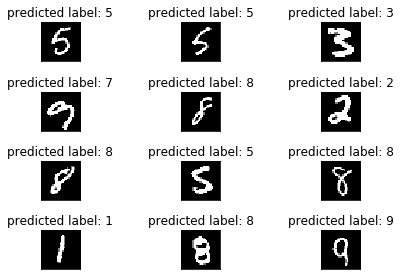

In [0]:
x_test = x_test.numpy()
x_test = flatten_input_pixels(x_test)
vis_predictions(x_test, test_predictions, len(test_predictions))

# 3. Summary

kNN and SVM are amongst the most popularly used classification models. Neural Networks are also highly being used nowadays because of the accuracy that they provide. 

The criteria for judging these models would broadly consist of:
</br>1) Time taken to train data
</br>2) Time taken to predict over test data
</br>3) Accuracy and error rate

While kNN takes a lesser time to train over the data, it has lesser accuracy as compared to SVM and Neural Networks. The evaluation time for kNN is also larger than of SVM and NN. Of the three it is found that kNN < SVM < CNN in terms of accuracy and training time. 
The number of hyperparameters required to tune kNN is also primarily just the value of K, while it is possible to refine the SVM and Neural Network models with more hyperparameters, thus making it easier for the models to "learn" over the range of training data. 
The performance of kNN also worsens in proportion to the data it has to handle. SVM and CNN take a significant training time, but require minimal computation for classification on test data. 